## All Packages needed

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

C:\Users\steve\AppData\Local\Temp\ipykernel_36436\91456258.py:14: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


device(type='cpu')

# Data loading & inspection
## Getting shape of CSV file
## And summary of data types

In [6]:
#Getting a summary of the number of images and the different class IDs

df = pd.read_csv('labels_train.csv')
df.shape
df


,file_name,class_id
0,img_4358977458434011046.jpg,1
1,img_5224016757187192130.jpg,2
2,img_3065202206106254707.jpg,2
3,img_6304894865561547174.jpg,1
4,img_3371338542810939877.jpg,2
...,...,...
4667,img_6661311872293090412.jpg,2
4668,img_3844568579349757418.jpg,1
4669,img_9145812369383814369.jpg,1
4670,img_1311393330250392648.jpg,1


In [7]:
# Need to create folders for each X-ray type to store the images
types = df['class_id'].unique()
print(types)

[1 2 0]


# Feature-level analysis

## There are 3 image classes:

Class 0: no disease

Class 1: bacterial pneumonia

Class 2: viral pneumonia

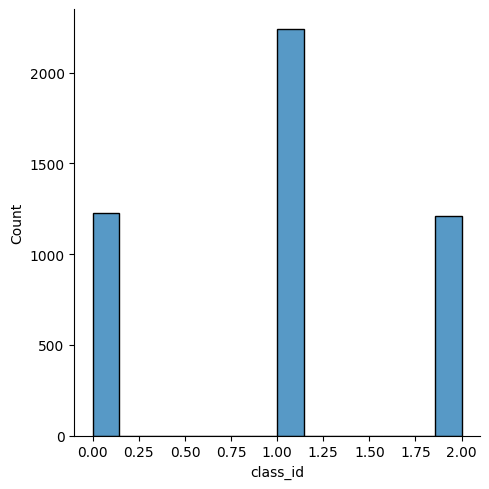

In [8]:
#visualization displot of the different classes and their image counts

sns.displot(df['class_id'])
plt.show()

## Discuss any class imbalance, possible bias, noise

There are many more bacterial image X-rays of pneumonia than there are normal and viral X-rays. We can fix this class imbalance with class weights.

## Missing values, outliers, duplicates

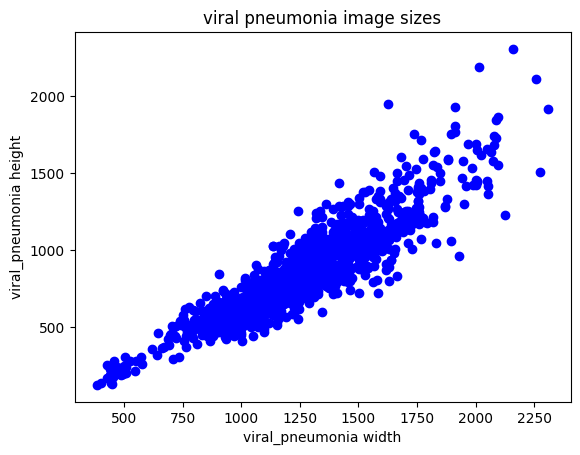

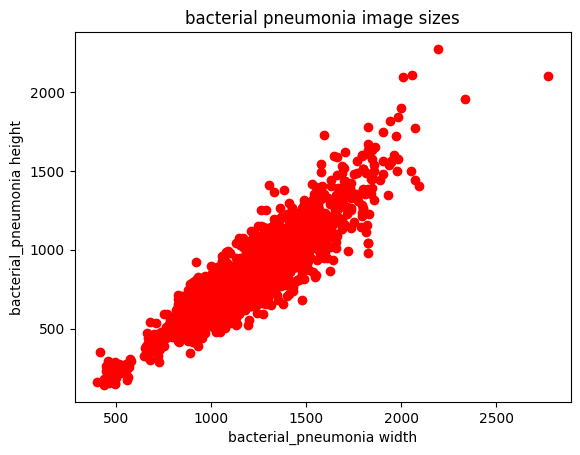

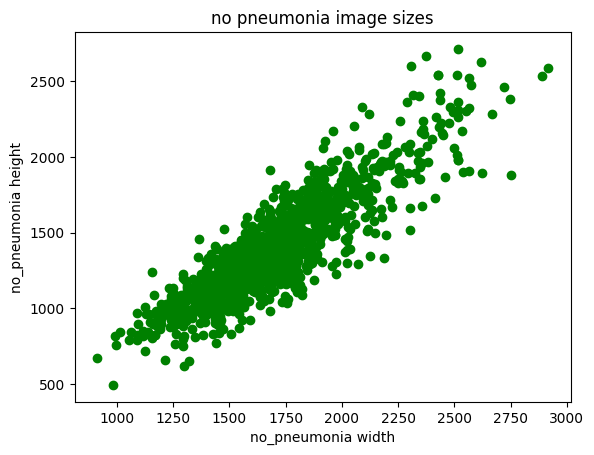

In [ ]:
# image size inconsistency
vp = os.listdir('viral_pneumonia')
image = Image.open('viral_pneumonia/' + vp[0])
classes = ['viral_pneumonia', 'bacterial_pneumonia', 'no_pneumonia']

vp_w, vp_h = [], []
bp_w, bp_h = [], []
np_w, np_h = [], []

for label in classes:
    for filename in os.listdir(label):
        image = Image.open(label + '/' + filename)
        w, h = image.size

        if(label == 'viral_pneumonia'):
            vp_w.append(w)
            vp_h.append(h)
        elif(label == 'bacterial_pneumonia'):
            bp_w.append(w)
            bp_h.append(h)
        else:
            np_w.append(w)
            np_h.append(h)

plt.scatter(vp_w, vp_h, color='blue')
plt.xlabel('viral_pneumonia width')
plt.ylabel('viral_pneumonia height')
plt.title("viral pneumonia image sizes")
plt.show()

plt.scatter(bp_w, bp_h, color='red')
plt.xlabel('bacterial_pneumonia width')
plt.ylabel('bacterial_pneumonia height')
plt.title("bacterial pneumonia image sizes")
plt.show()

plt.scatter(np_w, np_h, color='green')
plt.xlabel('no_pneumonia width')
plt.ylabel('no_pneumonia height')
plt.title("no pneumonia image sizes")
plt.show()



In [9]:
#This shows if there are any missing values in the 2 columns provided with the CSV file
df.isnull().sum()

file_name    0
class_id     0
dtype: int64

## Calculating class weights

This is to compensate for the class imbalance seen with the histogram.

In [10]:
# sizes of each class
classes = df['class_id'].unique()
total_images = df.shape[0]
class_weights = {}
class_frequencies = []

for c in classes:
    class_weights[c] = df['class_id'].value_counts().get(c, 0)
    class_frequencies.append(class_weights[c]/total_images)
    class_weights[c] = class_weights[c]/total_images

class_median = np.median(class_frequencies)

for c in class_weights:
    class_weights[c] = class_median/class_weights[c]
    print(f"{c} : {class_weights[c]}")

1 : 0.5482573726541554
2 : 1.0165700082850042
0 : 1.0


## Placing the images in their respective folders

In [23]:
import os
import shutil

disease_types = df['class_id'].unique()
folders = {}

for type in disease_types:
    if type == 0:
        folder_name = 'no_pneumonia'
    elif type == 1:
        folder_name = 'bacterial_pneumonia'
    else:
        folder_name = 'viral_pneumonia'

    folders[type] = folder_name
    
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    else:
        print("already exisits")



#each image from the chest X-ray dataset

for filename in os.listdir('train_images/train_images'): 
    image = df.loc[df['file_name'] == filename]
    img_class = image['class_id'].values[0]
    src = 'train_images/train_images/' + filename
    
    if img_class == 0:
        folder = "no_pneumonia"
        file_count = NP_count
        NP_count += 1
    elif img_class == 1:
        folder = "bacterial_pneumonia"
        file_count = BP_count
        BP_count += 1
    else:
        folder = "viral_pneumonia"
        file_count = VP_count
        VP_count += 1

    
    dest = folder + '/' + filename
    shutil.copy(src, dest)

print("Done!")

for folder in folders.values():
    num_images = len(os.listdir(folder))
    print(f"{folder}: {num_images} total images")

already exisits
already exisits
already exisits
Done!
bacterial_pneumonia: 2238 total images
viral_pneumonia: 1207 total images
no_pneumonia: 1227 total images


In [ ]:
NP_count = 0
BP_count = 0
VP_count = 0

for folder in folders.values():
    for filename in os.listdir(folder):
        
        if folder == "no_pneumonia":
            file_count = NP_count
            NP_count += 1
        elif folder == "bacterial_pneumonia":
            file_count = BP_count
            BP_count += 1
        else:
            file_count = VP_count
            VP_count += 1

        new_name = folder + '/' + folder + '_' + str(file_count) + '.jpg'
        old_name = folder + '/' + filename
        os.rename(old_name, new_name)

# Visualization

Show examples in each folder

## For image data: grid samples

We are a little limited with what we can visualize as our metadata only has the image class id and what image it corresponds to


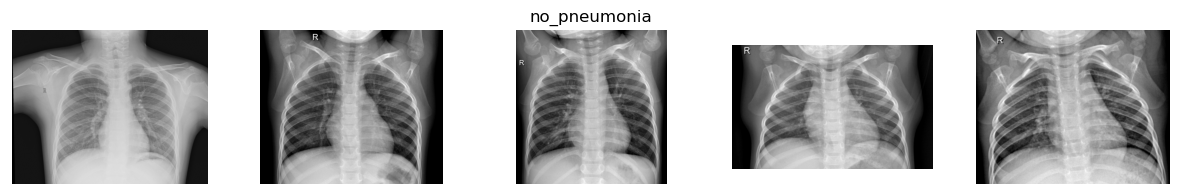

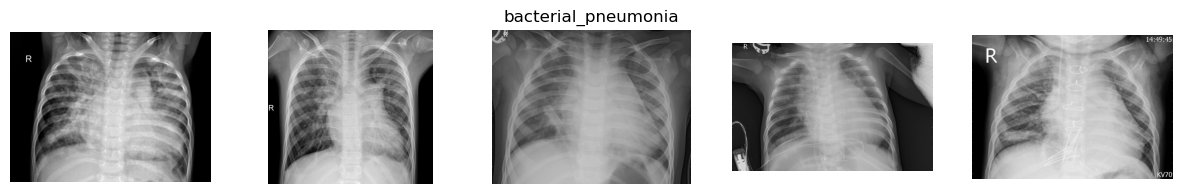

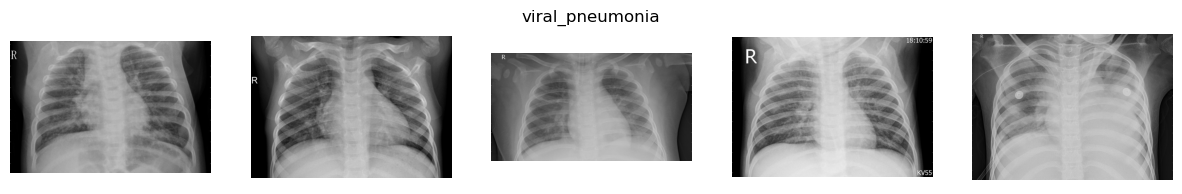

In [14]:
label = ['0', '1', '2']
label_images = []
classes = ['no_pneumonia', 'bacterial_pneumonia', 'viral_pneumonia']

for index, label in enumerate(classes):
    plt.figure(figsize=(15,2))
    plt.title(classes[index])
    plt.axis('off')

    for i in range(5):
        img = plt.imread(label+ '/' +os.listdir(label)[i])
        plt.subplot(1, 5, i +1)
        plt.axis('off')
        plt.imshow(img, cmap="gray")
    
    plt.show()

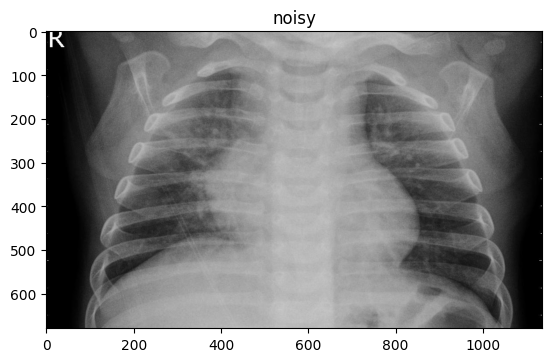

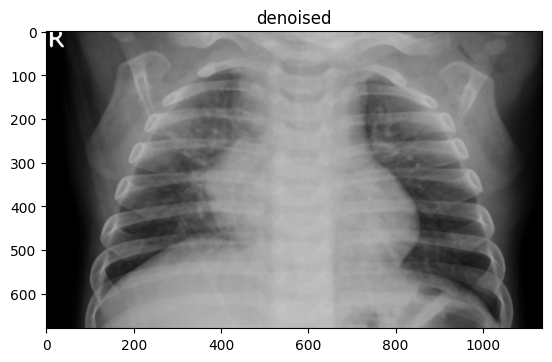

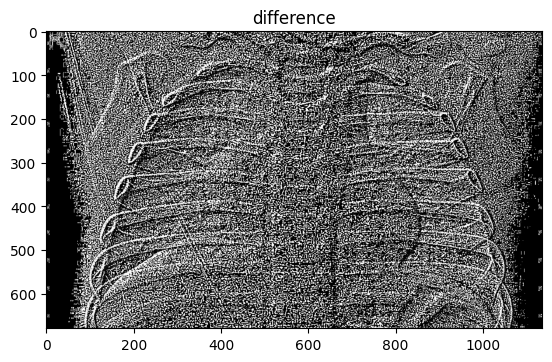

In [14]:
noisy_img = Image.open("viral_pneumonia/viral_pneumonia_100.jpg")
plt.title("noisy")
plt.imshow(noisy_img, cmap="gray")
plt.show()

filtered_img = scipy.ndimage.median_filter(noisy_img, size=6)
plt.title("denoised")
plt.imshow(filtered_img, cmap="gray")
plt.show()

diff_img = np.abs(filtered_img - noisy_img)
plt.title("difference")
plt.imshow(diff_img, cmap="gray")
plt.show()


## Preliminary plan for preprocessing
What needs fixing before modeling?

I believe the only thing left that needs fixing is the image size. Since images vary in size they will all needed to be transformed to the same size. We most likely will go with the proven 224x224 image size used in the skin lesion classification activity.